In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame
arr = np.array

# 读取数据

In [2]:
dirPath = "data preprocessed\\keep-all-necessary-feature\\normalized-[z-score]"

#means, stds = eval(open(dirPath + "\\means_and_stds_about_trainset.py").read())

trainSet_origin = np.loadtxt(dirPath + '\\train.csv', delimiter=",")
validateSet_origin = np.loadtxt(dirPath + '\\validate.csv', delimiter=",")
testSet = np.loadtxt(dirPath + '\\test.csv', delimiter=",")

trainSet_origin.shape, validateSet_origin.shape, testSet.shape

'------'

trainSet, trainSetLabel = trainSet_origin[:, :-1], trainSet_origin[:, -1]
validateSet, validateSetLabel = validateSet_origin[:, :-1], validateSet_origin[:, -1]

trainSet.shape, validateSet.shape

((13625, 60), (2990, 60), (742, 59))

'------'

((13625, 59), (2990, 59))

# 修改训练集的大小

用于测试训练集大小是否会影响算法表现的模块。

In [4]:
# split_line = 24*300
# trainSet = trainSet[:split_line, :]
# trainSetLabel = trainSetLabel[:split_line]

# trainSet.shape, trainSetLabel.shape

# 归一化预测标签值

In [5]:
mean_of_cnt, std_of_cnt = 0, 1

In [6]:
trainSetLabel.mean(), trainSetLabel.std() #处理前的均值和方差

(172.48080733944954, 164.98361847646188)

In [7]:
# mean_of_cnt, std_of_cnt = trainSetLabel.mean(), trainSetLabel.std()

# trainSetLabel = (trainSetLabel - mean_of_cnt)/std_of_cnt
# validateSetLabel = (validateSetLabel - mean_of_cnt)/std_of_cnt

# pd.concat([DF(trainSetLabel).describe(), DF(validateSetLabel).describe()], axis=1)

# 划分验证集最后21天进行测试

由于之前划分验证集时是直接取原有数据集的后18%作为验证集的，这里取验证集的后21天作为测试也相当于取原有数据集的后21天作为测试，保存了数据在时间上的连续性。

In [8]:
num = 21*24 # 数据个数
last21Days_range = np.arange(num) #样本范围
last21Days_features, last21Days_labels_origin = validateSet[-num:], validateSetLabel[-num:]

last21Days_labels_origin.shape, last21Days_range.shape

((504,), (504,))

# 损失函数实现

这里实现损失函数来衡量算法的准确率。

In [9]:
def calcLoss(predict, label):
    '''计算预测值相对于标签值的损失值，默认使用均方误差'''
    def RMeanSquareError(a, b):
        '''计算均方误差'''
        return np.sqrt(np.mean((a - b)**2))
    
    return RMeanSquareError(predict, label)

# 神经网络

In [10]:
class NeuralNetwork(object):
    '''神经网络类实现'''
    def __init__(self, n_input, n_hidden, n_output, learning_rate, lambad, SGD_batch_size=-1):
        '''初始化函数'''
        #设置 输入层、隐藏层、输出层结点个数
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        #设置 学习率
        self.lr = learning_rate
        #设置 激活函数
        self.activation_function = lambda x : 1/(1+np.exp(-x))
        #设置随机梯度下降每次抽取的样本个数，-1代表使用 批梯度下降
        self.SGD_batch_size = SGD_batch_size
        
        #初始化 输入层到隐藏层、隐藏层到输出层的权重矩阵为正态分布
        self.weights_input_to_hidden = np.random.normal(0, self.n_input**(-0.5),
                                                        (self.n_input+1, self.n_hidden))
        
        self.weights_hidden_to_hidden = np.random.normal(0, self.n_hidden**(-0.5),
                                                         (self.n_hidden+1, self.n_hidden))
        
        self.weights_hidden_to_output = np.random.normal(0, self.n_hidden**(-0.5),
                                                         (self.n_hidden+1, self.n_output))
        self.lambad = lambad
        
    def addOne2Rows(self, dataSet):
        '''给每一个样本前加一个常数1'''
        ones = np.ones(len(dataSet))
        return np.column_stack((ones, dataSet))

    def fit(self, features, labels):
        '''根据训练集训练算法'''
        #得到样本总数
        totSampleNum = features.shape[0]
        #初始化 权重步长矩阵
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_h = np.zeros(self.weights_hidden_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        #选取用于训练的样本
        sampleDatas, sampleLabels = features.copy(), labels.copy()
        if self.SGD_batch_size != -1:
            #从训练集中随机均匀无重复地抽取一定样本
            sampleIdxes = np.random.choice(totSampleNum, SGD_batch_size, replace=False)
            #得到采样后的一部分数据
            sampleDatas, sampleLabels = features[sampleIdxes], labels[sampleIdxes]
        #给训练集的每个样本前加上一
        sampleDatas = self.addOne2Rows(sampleDatas)
        #遍历
        for X, y in zip(sampleDatas, sampleLabels):
            ### 前向传播过程 ###
            #计算 隐藏层 输入和输出
            hidden_inputs_1 = np.dot(X, self.weights_input_to_hidden)
            hidden_outputs_1 = self.activation_function(hidden_inputs_1)
            hidden_outputs_1 = np.insert(hidden_outputs_1, 0, 1)
            
            hidden_inputs_2 = np.dot(hidden_outputs_1, self.weights_hidden_to_hidden)
            hidden_outputs_2 = self.activation_function(hidden_inputs_2)
            hidden_outputs_2 = np.insert(hidden_outputs_2, 0, 1)
            
            #计算 输出层 输入和输出
            final_inputs = np.dot(hidden_outputs_2, self.weights_hidden_to_output)
            final_outputs = final_inputs #final_outputs=f(final_inputs)=final_inputs
        
            ###########################################################
            ### 后向传播过程 ###
            ######## 隐藏层到输出层 ########
            #计算 输出层输出 和 目标标签值 的误差
            error = y - final_outputs
            #计算 输出层 误差梯度
            output_error_term = error # = error*1
            #更新 隐藏层到输出层 的 权重步长矩阵(广播运算，或者外积）
            delta_weights_h_o += hidden_outputs_2.reshape(-1,1)*output_error_term
            
            ######## 隐藏层1到隐藏层2 ########
            hidden2_error = np.dot(self.weights_hidden_to_output[1:, :], output_error_term)
            hidden2_error_term = hidden2_error*hidden_outputs_2[1:]*(1-hidden_outputs_2[1:])
            delta_weights_h_h += hidden_outputs_1.reshape(-1,1)*hidden2_error_term
                
            ######## 输入层到隐藏层 ########
            #计算 传播到 隐藏层 的误差
            hidden1_error = np.dot(self.weights_hidden_to_hidden[1:, :], hidden2_error_term)
            #计算 隐藏层 误差梯度
            hidden1_error_term = hidden1_error*hidden_outputs_1[1:]*(1-hidden_outputs_1[1:])
            # 更新 输入层到隐藏层 的 权重步长矩阵(广播运算，或者外积）
            delta_weights_i_h += X.reshape(-1,1)*hidden1_error_term
            ###########################################################
            
        #正则化项
        delta_weights_i_h[1:,:] += self.lambad*self.weights_input_to_hidden[1:,:]
        delta_weights_h_h[1:,:] += self.lambad*self.weights_hidden_to_hidden[1:,:]
        delta_weights_h_o[1:,:] += self.lambad*self.weights_hidden_to_output[1:,:]
        
        #更新 权重矩阵
        self.weights_hidden_to_output += self.lr*delta_weights_h_o/totSampleNum
        self.weights_hidden_to_hidden += self.lr*delta_weights_h_h/totSampleNum
        self.weights_input_to_hidden  += self.lr*delta_weights_i_h/totSampleNum       
 
    def apply(self, features):
        '''应用训练好的参数到输入数据集上'''
        features = self.addOne2Rows(features)
        hidden_inputs_1 = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs_1 = self.activation_function(hidden_inputs_1)
        hidden_outputs_1 = self.addOne2Rows(hidden_outputs_1)
        
        hidden_inputs_2 = np.dot(hidden_outputs_1, self.weights_hidden_to_hidden)
        hidden_outputs_2 = self.activation_function(hidden_inputs_2)
        hidden_outputs_2 = self.addOne2Rows(hidden_outputs_2)
        
        final_inputs = np.dot(hidden_outputs_2, self.weights_hidden_to_output)
        final_outputs = final_inputs 
        
        return final_outputs
    
    
### 需调参的参数 ###
learning_rate = 0.5
n_hidden = 22
SGD_batch_size = 256
runTime = 1000
lambad = 0.05
### 不需调参的参数 ###
n_output = 1
n_input = trainSet.shape[1]

network = NeuralNetwork(n_input, n_hidden, n_output, learning_rate, lambad, SGD_batch_size)
network.fit(trainSet, trainSetLabel)
network.apply(trainSet)

array([[ 11.38516669],
       [ 11.39420807],
       [ 11.36494564],
       ..., 
       [ 11.22440435],
       [ 11.27269123],
       [ 11.24086257]])

# 调参

参考[神经网络学习之参数的设置原则][神经网络学习之参数的设置原则]进行调参。需要调参的参数有：学习率、隐藏层个数、随机梯度下降使用的样本的个数。

[神经网络学习之参数的设置原则]:https://www.cnblogs.com/sunfie/p/5519604.html

## 绘制损失值随迭代此时变化的曲线

In [11]:
def show_loss_fig(test_range, train_loss, validate_loss, fileName="test_loss.png", showFig=True):
    fig, ax = plt.subplots() 
    fig.set_size_inches(10.5, 4)
    plt.plot(test_range, train_loss, 'r', label="Training loss")
    plt.plot(test_range, validate_loss, 'g', label="Validation loss")
    plt.xlabel('run time')
    plt.ylabel('loss')
    plt.title("loss versus rum time in Neural Network")
    plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0., fontsize='small')
    if showFig:
        plt.show()
    else:
        plt.savefig(fileName)
    plt.close()

# show_loss_fig(testRange, trainLosses*std_of_cnt+mean_of_cnt,
#               validationLosses*std_of_cnt+mean_of_cnt)

## 绘制对验证集后21天的预测值与实际值的对比图

In [12]:
def show_last21Days_fig(test_range, predict, label, fileName="test_last21Days.png", showFig=True):
    fig, ax = plt.subplots() 
    fig.set_size_inches(10.5, 4)
    plt.plot(test_range, predict, 'r', label="prediction")
    plt.plot(test_range, label, 'g', label="data")
    ax.set_xlim(right=num)
    ax.set_xticks(np.arange(0, num+24, 24))
    ax.set_xticklabels(np.arange(0, 22, 1))
    plt.xlabel('day')
    plt.ylabel('count of total rental bikes')
    plt.title("count of total rental bikes versus time")
    plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0., fontsize='small')
    if showFig:
        plt.show()
    else:
        plt.savefig(fileName)
    plt.close()

# #使用算法进行预测
# last21Days_predicts = network.apply(last21Days_features)
# #还原归一化后的数据
# last21Days_predicts = (last21Days_predicts.flatten()*std_of_cnt + mean_of_cnt).astype('int64')
# last21Days_labels = (last21Days_labels_origin.flatten()*std_of_cnt + mean_of_cnt).astype('int64')

# show_last21Days_fig(last21Days_range, last21Days_predicts, last21Days_labels)    

## 绘制损失函数变化曲线

In [13]:
def show_cost_fig(test_range, train_costs, validate_costs, fileName="test_last21Days.png", showFig=True):
    fig, ax = plt.subplots() 
    fig.set_size_inches(10.5, 4)
    plt.plot(test_range, train_costs, 'r', label="train")
    plt.plot(test_range, validate_costs, 'g', label="validate")
    plt.xlabel('run time')
    plt.ylabel('cost')
    if showFig:
        plt.show()
    else:
        plt.savefig(fileName)
    plt.close()

## 计算正则化项

In [14]:
def calcCostFunc(weight_input_to_hidden, weight_hidden_to_output, lambad, error):
    a = 1/2*np.mean(error**2)
    b = lambad/2*(np.sum(weight_input_to_hidden[1:,:]**2) + np.sum(weight_hidden_to_output[1:,:]**2))
    return a+b

## 多次迭代运行算法

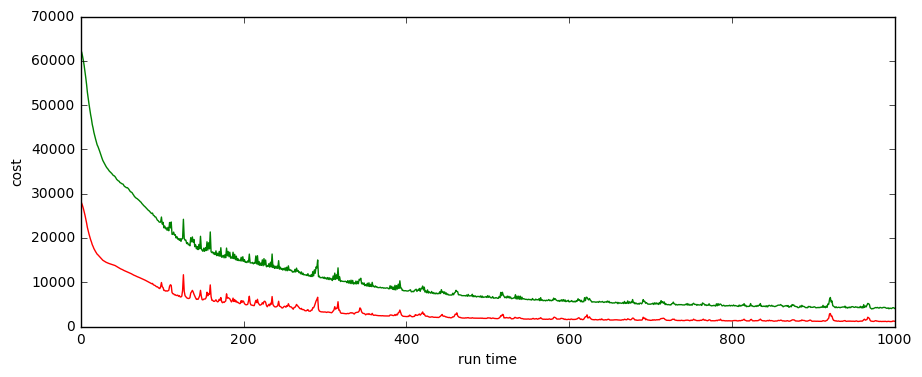

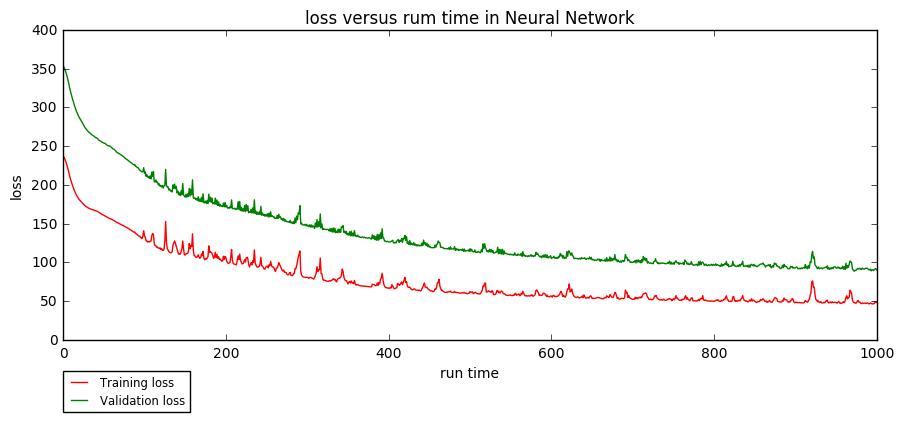

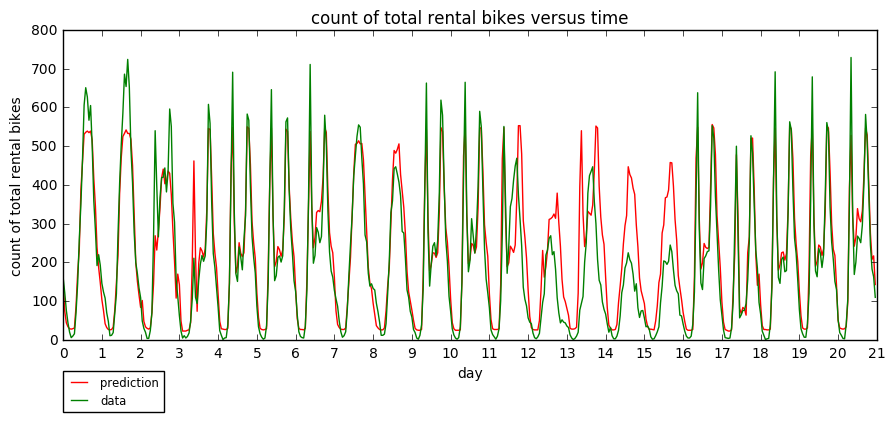

In [24]:
### 需调参的参数 ###
learning_rate = 0.1105
n_hidden = 22
SGD_batch_size = 256
runTime = 1000
lambad = 0.01
### 不需调参的参数 ###
n_output = 1
n_input = trainSet.shape[1]

network = NeuralNetwork(n_input, n_hidden, n_output, learning_rate, lambad, SGD_batch_size)


testRange = range(1, runTime+1)
trainLosses, validationLosses= np.zeros(runTime), np.zeros(runTime)
trainCosts, validationCosts= np.zeros(runTime), np.zeros(runTime)
for i in tnrange(runTime):
    #使用数据训练算法
    network.fit(trainSet, trainSetLabel)
    #得到算法对 训练集 和 验证集 的预测标签
    trainPredictLabel = network.apply(trainSet).T
    validPredictLabel = network.apply(validateSet).T
    #计算 损失值 并 保存 损失值结果
    trainLosses[i] = calcLoss(trainPredictLabel, trainSetLabel)
    validationLosses[i] = calcLoss(validPredictLabel, validateSetLabel)
    #计算损失函数
    trainCosts[i] = calcCostFunc(network.weights_input_to_hidden,
                            network.weights_input_to_hidden, lambad, trainPredictLabel-trainSetLabel)
    #计算损失函数
    validationCosts[i] = calcCostFunc(network.weights_input_to_hidden,
                            network.weights_input_to_hidden, lambad, validateSetLabel-validPredictLabel)

show_cost_fig(testRange, trainCosts, validationCosts)    
show_loss_fig(testRange, trainLosses*std_of_cnt+mean_of_cnt, validationLosses*std_of_cnt+mean_of_cnt)

#使用算法进行预测
last21Days_predicts = network.apply(last21Days_features)
#还原归一化后的数据
last21Days_predicts_back = np.round(last21Days_predicts.flatten()*std_of_cnt + mean_of_cnt)
last21Days_labels = np.round(last21Days_labels_origin.flatten()*std_of_cnt + mean_of_cnt)

show_last21Days_fig(last21Days_range, last21Days_predicts_back, last21Days_labels)    

ansLabel = network.apply(testSet).flatten()*std_of_cnt + mean_of_cnt
ansLabel = np.round(ansLabel)
np.savetxt('.\\rank\\47_v1.csv', ansLabel, fmt="%d", delimiter="\n")